In [1]:
# This notebook implements 2D CNN (VGG16) as feature extractor
# and implements 3D CNN for final prediction

In [2]:
# The code is written to reuse as much memory as possible to
# minimize the memory usage as the amount of data (extracted images)
# is large and I have only 16 GB of RAM space

In [3]:
# My system comfiguration:
# 16 GB RAM
# 1 TB HDD
# 256 GB SSD
# NVIDIA GTX 1070 8 GB GPU RAM
# I7 8th GEN Intel CPU

In [4]:
# for loading images
import glob

# for image array processing
import numpy as np
import pandas as pd

# for maintaing system path
import os

# for processing images
import cv2
import matplotlib.pyplot as plt

# encoding labels catogories
from sklearn.preprocessing import LabelEncoder
# multi class encoding
from sklearn.preprocessing import OneHotEncoder

# pretrained model
from keras.applications import vgg16

# Our 3D model
from keras.models import Model
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, InputLayer
from keras.utils import to_categorical
import h5py

%matplotlib inline

Using TensorFlow backend.
C:\Users\Light\anaconda3\envs\dogs-vs-cats\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Light\anaconda3\envs\dogs-vs-cats\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Light\anaconda3\envs\dogs-vs-cats\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Light\anaconda3\e

In [5]:
# train and validation directories
train_dir = 'D:\\something-something-project\\train-images\\'
validation_dir = 'D:\\something-something-project\\validation-images\\'

In [6]:
# listing images directory for train and validation
train_files = os.listdir(train_dir)
print (train_files)

validation_files = os.listdir(validation_dir)
print (validation_files)

['Dropping_something', 'Holding_something', 'Moving_something', 'Picking_something', 'Poking_something', 'Pouring_something', 'Putting_something', 'Showing_something', 'Tearing_something']
['Dropping_something', 'Holding_something', 'Moving_something', 'Picking_something', 'Poking_something', 'Pouring_something', 'Putting_something', 'Showing_something', 'Tearing_something']


In [7]:
# generating the full system path
train_files_dir = []
validation_files_dir = []

for f in train_files:
    if os.path.join(train_dir, f):
        train_files_dir.append(os.path.join(train_dir, f))
        
for f in validation_files:
    if os.path.join(validation_dir, f):
        validation_files_dir.append(os.path.join(validation_dir, f))
        
print (train_files_dir)
print (validation_files_dir)

['D:\\something-something-project\\train-images\\Dropping_something', 'D:\\something-something-project\\train-images\\Holding_something', 'D:\\something-something-project\\train-images\\Moving_something', 'D:\\something-something-project\\train-images\\Picking_something', 'D:\\something-something-project\\train-images\\Poking_something', 'D:\\something-something-project\\train-images\\Pouring_something', 'D:\\something-something-project\\train-images\\Putting_something', 'D:\\something-something-project\\train-images\\Showing_something', 'D:\\something-something-project\\train-images\\Tearing_something']
['D:\\something-something-project\\validation-images\\Dropping_something', 'D:\\something-something-project\\validation-images\\Holding_something', 'D:\\something-something-project\\validation-images\\Moving_something', 'D:\\something-something-project\\validation-images\\Picking_something', 'D:\\something-something-project\\validation-images\\Poking_something', 'D:\\something-somethin

In [8]:
# del train_files
# del validation_files

In [9]:
# printing number of images in each directories
print ("Training Data")
for d in train_files_dir:
    print (d, len(os.listdir(d)))

Training Data
D:\something-something-project\train-images\Dropping_something 15941
D:\something-something-project\train-images\Holding_something 25433
D:\something-something-project\train-images\Moving_something 56940
D:\something-something-project\train-images\Picking_something 3841
D:\something-something-project\train-images\Poking_something 14179
D:\something-something-project\train-images\Pouring_something 7280
D:\something-something-project\train-images\Putting_something 64208
D:\something-something-project\train-images\Showing_something 15682
D:\something-something-project\train-images\Tearing_something 11816


In [10]:
# printing number of images in each directories
print ("Validation Data")
for d in validation_files_dir:
    print (d, len(os.listdir(d)))

Validation Data
D:\something-something-project\validation-images\Dropping_something 3108
D:\something-something-project\validation-images\Holding_something 4148
D:\something-something-project\validation-images\Moving_something 7463
D:\something-something-project\validation-images\Picking_something 774
D:\something-something-project\validation-images\Poking_something 1618
D:\something-something-project\validation-images\Pouring_something 2023
D:\something-something-project\validation-images\Putting_something 7867
D:\something-something-project\validation-images\Showing_something 2627
D:\something-something-project\validation-images\Tearing_something 3851


In [11]:
# loading training data
train_data = []
train_labels = []
for d in train_files_dir:
    print ('Directory: ', d)
    # commenting out so that one can read all the images, I have less RAM
    count = 0
    files = glob.glob(d + "/*.jpg")
    imgs = []
    for img in files:
        # print (img)
        if count == 1000:
            break
        if not os.path.isfile(img):
            continue
        imgs.append(cv2.imread(img))
        train_labels.append(d.split("D:\\something-something-project\\train-images\\")[1])
        count += 1
    train_data = train_data + imgs

Directory:  D:\something-something-project\train-images\Dropping_something
Directory:  D:\something-something-project\train-images\Holding_something
Directory:  D:\something-something-project\train-images\Moving_something
Directory:  D:\something-something-project\train-images\Picking_something
Directory:  D:\something-something-project\train-images\Poking_something
Directory:  D:\something-something-project\train-images\Pouring_something
Directory:  D:\something-something-project\train-images\Putting_something
Directory:  D:\something-something-project\train-images\Showing_something
Directory:  D:\something-something-project\train-images\Tearing_something


In [12]:
# loading validation data
validation_data = []
validation_labels = []
for d in validation_files_dir:
    print ('Directory: ', d)
    count = 0
    files = glob.glob(d + "/*.jpg")
    imgs = []
    for img in files:
        if count == 500:
            break
        if not os.path.isfile(img):
            continue
        imgs.append(cv2.imread(img))
        validation_labels.append(d.split("D:\\something-something-project\\validation-images\\")[1])
        count += 1
    validation_data = validation_data + imgs

Directory:  D:\something-something-project\validation-images\Dropping_something
Directory:  D:\something-something-project\validation-images\Holding_something
Directory:  D:\something-something-project\validation-images\Moving_something
Directory:  D:\something-something-project\validation-images\Picking_something
Directory:  D:\something-something-project\validation-images\Poking_something
Directory:  D:\something-something-project\validation-images\Pouring_something
Directory:  D:\something-something-project\validation-images\Putting_something
Directory:  D:\something-something-project\validation-images\Showing_something
Directory:  D:\something-something-project\validation-images\Tearing_something


In [13]:
print ("Train Data: ", len(train_data), "\tTrain Labels: ", len(train_labels))
print ("Validation Data: ", len(validation_data), "\tValidation Labels: ", len(validation_labels))

Train Data:  9000 	Train Labels:  9000
Validation Data:  4500 	Validation Labels:  4500


In [32]:
# Training Data (there are some corrupted files, so use the next column)
IMG_DIM = (84, 84)

train_imgs = [img_to_array(cv2.resize(img, IMG_DIM)) for img in train_data]
train_imgs = np.array(train_imgs)

validation_imgs = [img_to_array(cv2.resize(img, IMG_DIM)) for img in validation_data]
validation_imgs = np.array(validation_imgs)

In [15]:
# # Training Data
# # since there are few corrupted images, we need to remove that label as well
# IMG_DIM = (84, 84)
# train_imgs = []
# validation_imgs = []

# i = 0

# while i < len(train_data):
#     try:
#         train_imgs.append(img_to_array(cv2.resize(img, IMG_DIM)))
#         i += 1
#     except Exception as e:
#         print ('Exception found: ', e)
#         # delete from label as well
#         del train_labels[i]
#         i += 1
#         continue
        
# train_imgs = np.array(train_imgs)
        
# i = 0

# while i < len(validation_data):
#     try:
#         validation_imgs.append(img_to_array(cv2.resize(img, IMG_DIM)))
#         i += 1
#     except Exception as e:
#         print ('Exception found: ', e)
#         # delete from label as well
#         del validation_labels[i]
#         i += 1
#         continue
        
# validation_imgs = np.array(validation_imgs)

In [33]:
print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (9000, 84, 84, 3) 	Validation dataset shape: (4500, 84, 84, 3)


(84, 84, 3)


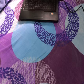

In [34]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [35]:
# parameters
batch_size = 30
num_classes = 9
epochs = 30
input_shape = (84, 84, 84, 3)

# one hot encoding for training and validation
label_encoder = LabelEncoder()
train_labels_integer_encoded = label_encoder.fit_transform(train_labels)
validation_labels_integer_encoded = label_encoder.fit_transform(validation_labels)

# print(train_labels_integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
train_labels_integer_encoded = train_labels_integer_encoded.reshape(len(train_labels_integer_encoded), 1)
train_label_enc = onehot_encoder.fit_transform(train_labels_integer_encoded)

validation_labels_integer_encoded = validation_labels_integer_encoded.reshape(len(validation_labels_integer_encoded), 1)
validation_label_enc = onehot_encoder.fit_transform(validation_labels_integer_encoded)

# print(train_labels[1495:1505], train_labels_enc[1495:1505])

# # invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)


In [36]:
# using pretrained VGG16 model

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

ValueError: `input_shape` must be a tuple of three integers.


(1, 2, 2, 512)


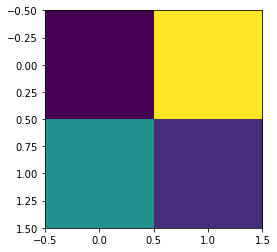

In [20]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [21]:
# getting the output format of VGG16 to make it sync with our output layer

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (9000, 2048) 	Validation Bottleneck Features: (4500, 2048)


In [29]:
# designing our output layer
# Create the model
model = Sequential()
# model.add(vgg_model)
# model.add(InputLayer(input_shape=(input_shape,)))
# model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# # Fit data to model
# history = model.fit(X_train, targets_train,
#             batch_size=128,
#             epochs=40,
#             verbose=1,
#             validation_split=0.3)



# input_shape = vgg_model.output_shape[1]

# model = Sequential()
# model.add(InputLayer(input_shape=(input_shape,)))
# model.add(Dense(512, activation='relu', input_dim=input_shape))
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(9, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=1e-4),
#               metrics=['accuracy'])

# model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 82, 82, 82, 32)    2624      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 41, 41, 41, 32)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 41, 41, 41, 32)    128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 41, 32)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 39, 39, 39, 64)    55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 19, 19, 19, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 19, 19, 64)   

In [30]:
# running the model
history = model.fit(x=train_features_vgg, y=train_label_enc,
                    validation_data=(validation_features_vgg, validation_label_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

ValueError: Error when checking input: expected conv3d_6_input to have 5 dimensions, but got array with shape (9000, 2048)